**Authors**: Malthe D. Andersen (s194257), Yucheng Fu (s194241), Andreas Høst (s194238)

In [28]:
# packages
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
from tqdm.notebook import tqdm
import pickle
import requests
import re
import random
import nltk
import numpy as np
import mwparserfromhell
import urllib.request
import json
import matplotlib.pyplot as plt 
import os
import seaborn as sns
import networkx as nx
import community
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Scraping the data

In the following sections, we scrape the [major characters](https://wowpedia.fandom.com/wiki/Major_characters) in the games and their meta data using the BeautifulSoup module. 

The function ``get_importance`` is a helper function that takes 'soup' as input and outputs the importance rating (red, orange, yellow, or green) for the character which the 'soup' belongs to.

In [12]:
games = ['WC1','WC2','WC2X','WC3','WC3X','WoW','WoWBC','WoWWotLK','WoWC','WoWMoP','WoWWoD','WoWL','WoWBfA','WoWS','WoWD']

def get_importance(soup):
    colors = []

    i = 0
    soup_a = soup.select("ul > li")
    for a in soup_a:
        color = re.findall(r'color+:\w+', str(a))

        if len(color) > 0:
            if i > 3:
                colors.append(color[0][6:])
            i += 1
            
    return colors

The ``get_metadata`` function outputs a list of dictionaries with the keys "Name", "Importance". The dictionary also contains information about which game each major character appears in. 

In [13]:
def get_metadata():
    meta_data = []

    # get meta data of all major characters

    url = "https://wowpedia.fandom.com/wiki/Major_characters"
    html = urlopen(url).read()
    soup = BeautifulSoup(html, features="html.parser")

    soup_a = soup.select("p > small")
    soup_b = soup.select("p > a")
    soup_b = [b for b in soup_b if "Katrana" not in str(b) and "Daval" not in str(b)]
    
    colors = get_importance(soup)
            
    for i,s in enumerate(soup_a):
        d = {}

        expansions = s.text.replace(",","").replace("—","").split()
        # make one-hot encoding for games. For each character, a "1" denotes that the character appears in that game, a "0" 
        # the character does not appear in the game.
        expansions = [int(1) if i in expansions else int(0) for i in games]

        text = soup_b[i]['href'][6:]
        color = colors[i]
        
        name = text.replace("%27", "'")

        if 1 in expansions:
            d['Name'] = name
            d['Importance'] = color
            for j,g in enumerate(games):
                d[g] = int(expansions[j])


            meta_data.append(d)
    
    return meta_data

In [10]:
# create dataframe for major characters and their meta data. Then save as .pickle file.

meta_data = get_metadata()
df_meta = pd.DataFrame(meta_data, dtype=object)

with open('df_meta.pickle', 'wb') as handle:
    pickle.dump(df_meta, handle, protocol=pickle.HIGHEST_PROTOCOL)

The ``get_major_characters`` function returns a list of dictionaries for all the names of the major characters. We will use these to find all the characters that are mentioned by the major characters.

In [21]:
def get_major_characters():
    characters = []

    url = "https://wowpedia.fandom.com/wiki/Major_characters"
    html = urlopen(url).read()
    soup = BeautifulSoup(html, features="html.parser")

    soup_a = soup.select("p > small")
    soup_b = soup.select("p > a")
    soup_b = [b for b in soup_b if "Katrana" not in str(b) and "Daval" not in str(b)]
    
    for i,s in enumerate(soup_a):
        d = {}

        expansions = s.text.replace(",","").replace("—","").split()
        expansions = [int(1) if i in expansions else int(0) for i in games]

        text = soup_b[i]['href'][6:]
        name = text.replace("%27", "'")

        if 1 in expansions:
            d['Name'] = name
            
            characters.append(d)
    
    return characters

# make dataframe 
characters = get_major_characters()
df = pd.DataFrame(characters)

The function ``get_wikicode`` is a helper function to access the raw wiki text on Wowpedia, using the Wowpedia API. The input is a character name 't', e.g. Deathwing, and the output is the raw wiki text.

In [24]:
def get_wikicode(t):

    response = requests.get(
         'https://wowpedia.fandom.com/api.php',
             params={
             'action': 'query',
             'format': 'json',
             'titles': '{}'.format(t),
             'prop': 'revisions',
             'rvprop': 'content',
         }
     ).json()


    page = next(iter(response['query']['pages'].values()))

    wikicode = page['revisions'][0]['*']
    
    return wikicode

The following code loops through all the major characters and find characters that are linked from the major character's wiki page. 

We check all hyperlinks on the major character's wiki page. The hyperlinks may link to characters, locations, events, and other miscellaneous pages, but common for all character pages is that only they have an information table with the gender displayed. If the linked page has an information table with the gender displayed, it is a character, and we append them to the character list.

The code takes around 6 hours to run.


In [1]:
characters = []

for i,name in enumerate(tqdm(list(df['Name']))):
    
    text = get_wikicode(name)

    WORD_RE = re.compile(r"\[{2}.*?\]{2}")
    for word in list(np.unique(WORD_RE.findall(text))):
        try:
            char = word.replace(" ", "_")[2:-2]
            if "Category" not in char and ":" not in char and "#" not in char and "|" not in char:
                url = "https://wowpedia.fandom.com/wiki/{}".format(char)
                html = urlopen(url).read()
                soup = BeautifulSoup(html, features="html.parser")
                
                # find the information table
                table =  soup.find("table",{"class":"infobox darktable"})

                if len(table) > 0:

                    text = table.text
                    # check if the infobox displays gender.
                    if "Gender" not in text:
                        pass
                    else:
                        characters.append(char)

        except:
            pass

# there are duplicate characters which we remove. 
characters = list(np.unique(characters))



Furthermore, we perform some manual clean up and filter any character that has some non-alphanumeric characters in the name. Also filter characters that already exist in the data frame.

In [ ]:
filter_characters = []
for char in characters:
    if "/" not in char and "#" not in char and "|" not in char and "tactics" not in char and char not in list(df_meta['Name']):
        filter_characters.append(char)

# append to the existing dataframe with the name of major characters.
df = df.append(pd.DataFrame(filter_characters, columns=['Name']), ignore_index=True)

Now we have collected the characters we will be working with. The next step is to find the affiliation and race of each character.

The functions ``get_race``, ``get_affiliation``, and ``get_race_and_affiliation`` are helper functions. The input to the ``get_race_and_affiliation`` is the infobox from a character's wiki page, and it outputs the Race and Affiliation (using the two other helper functions), which is displayed in the infobox. The affiliations can be either Horde, Alliance or "Other". If the listed affiliation for a character is neither Horde nor Alliance, its affiliation is assigned as "Other". 

In [ ]:
def get_race(tokens, i):
    regex2 = "^[a-zA-z-' ]+[a-zA-Z ]+"
    
    regex_expressions = re.findall(regex2, tokens[i+1])
    
    # join into word
    race = " ".join(regex_expressions).strip()
    
    return race

def get_affiliation(tokens, i):
    regex3 = '[a-zA-z ]+'
    
    to_string = ' '.join(tokens[i:])
    regex_expressions = re.findall(regex3, to_string)
    regex_expressions = [k.strip() for k in regex_expressions]

        
    for i, exp in enumerate(regex_expressions):
        if "Former" in exp:
            break
    regex_expressions = regex_expressions[:i+1]
    
    if any(["Horde" in i for i in regex_expressions]):
        affiliation = "Horde"
    elif any(["Alliance" in i for i in regex_expressions]):
        affiliation = 'Alliance'
    else:
        affiliation = 'Other'
        
    return affiliation

def get_race_and_affiliation(text):

    regex1 = '[a-zA-Z][^A-Z]*'
    
    tokens_race = text.split("\n")
    tokens_affiliation = re.findall(regex1, text.replace("\n",""))

    race = '0'
    affiliation = 'Other'

    for i, word in enumerate(tokens_race):
        if 'Race' in word:
            race = get_race(tokens_race,i)
    for i, word in enumerate(tokens_affiliation):
        if 'Affiliation' in word:
            affiliation = get_affiliation(tokens_affiliation,i)
    
    return race, affiliation


The following code loops through all the characters and outputs a list of races and affiliations for all the characters. The list of races and affiliations are inserted as new columns in the dataframe. 

In [ ]:
races = []
affiliations = []

for name in tqdm(list(df['Name'])):
    try:
        name = name.split("/")[0]
        url = "https://wowpedia.fandom.com/wiki/{}".format(name)
        html = urlopen(url).read()
        soup = BeautifulSoup(html, features="html.parser")
        
        # find information table on characterp page
        table =  soup.find("table",{"class":"infobox darktable"})

        text = table.text

        race, affiliation = get_race_and_affiliation(text)

        races.append(race)
        affiliations.append(affiliation)
    except:
        print(name)
        races.append('0')
        affiliations.append('Other')
        
df.insert(1, 'Race', races)
df.insert(2, 'Affiliation', affiliations)

The infobox lists basic information about the character, such as "Race", "Affiliation(s)", "Former affiliation(s)", "Occupation" etc. Due to how the information is formatted, it might occur that the scraped races might contain artefacts. For instance, there are instances where the race is "TrollAffiliation". These artefacts are removed manually with the code below. 

In [ ]:
races2 = []
for race in df['Race']:
    if race != 0:
        race = race.replace("Affiliation", "").replace("Race", "").replace("Occupation", "").replace("Reaction", "").replace("Resource", "").replace("Race", "").replace("Class", "").replace("Former affiliation", "").replace("Location","").replace("Level", "").replace("Status", "")

    races2.append(race)

df['Race'] = races2

Lastly, for each character we scrape the clean text and find which other characters is linked to. This is done with the code in the following two cells. In some instances, the wiki page is a redirect. This is handled by following the redirect link, and then extracting the information from that page. 

The clean text and links are added to the dataframe as columns.

In [ ]:
text_list = []
for name in tqdm(df['Name']):
    response = requests.get(
         'https://wowpedia.fandom.com/api.php',
             params={
             'action': 'query',
             'format': 'json',
             'titles': '{}'.format(name),
             'prop': 'revisions',
             'rvprop': 'content',
         }
     ).json()

    page = next(iter(response['query']['pages'].values()))
    try:
        wikicode = page['revisions'][0]['*']
        parsed_wikicode = mwparserfromhell.parse(wikicode).strip_code()
        
        # handle redirects
        if parsed_wikicode[:8].upper() == 'REDIRECT':
            t = parsed_wikicode[8:].strip().replace(" ", "_").split("\n")[0]
    
            response = requests.get(
                 'https://wowpedia.fandom.com/api.php',
                     params={
                     'action': 'query',
                     'format': 'json',
                     'titles': '{}'.format(t),
                     'prop': 'revisions',
                     'rvprop': 'content',
                 }).json()

            page = next(iter(response['query']['pages'].values()))
            wikicode2 = page['revisions'][0]['*']
            parsed_wikicode2 = mwparserfromhell.parse(wikicode2).strip_code()

            text_list.append(parsed_wikicode2)
        
        else:
            text_list.append(parsed_wikicode)
    except:
        text_list.append(" ")
    
df.insert(3,'Clean Text',text_list)

In [ ]:
baseurl = "https://wowpedia.fandom.com/api.php?"
action = "action=query"
title = "titles={}"
content = "prop=revisions&rvprop=content"
dataformat ="format=json"

WORD_RE = re.compile(r"\[{2}.*?\]{2}")

link_list=[]
for name in tqdm(list(df['Name'])):
    name = ""
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title.format(name), dataformat)
    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')

    links = []
    # handle redicts
    if "#REDIRECT" in wikitext.upper():
        t = re.findall(r"\[{2}.*?\]{2}", wikitext)[0]
        t = t[2:-2].replace(" ", "_").split("|")[0]
        query = "{}{}&{}&{}&{}".format(baseurl, action, content, title.format(t), dataformat)
        wikiresponse = urllib.request.urlopen(query)
        wikidata = wikiresponse.read()
        wikitext2 = wikidata.decode('utf-8')
 
        for word in WORD_RE.findall(wikitext2):
            word = word[2:-2].replace(" ", "_").split("|")[0]
            if word in list(df['Name']) and word not in links:
                links.append(word)
        link_list.append(np.unique(links))

    else:
        for word in WORD_RE.findall(wikitext):
            word = word[2:-2].replace(" ", "_").split("|")[0]
            if word in list(df['Name']) and word not in links:
                links.append(word)
        link_list.append(np.unique(links))
    
df.insert(4,'Out Links',link_list)

We have now scraped all the data that we need! The dataframe is dumped to a pickle file, so we can load it easier.

In [ ]:
with open('df_text.pickle', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Network

## Creating the network

## Graphing

## Importance

We create box plots for the degree centrality and betweenness centrality for the major characters. We use the graph G that we created earlier, as well as the meta data dataframe. 

In [9]:
with open('df_meta.pickle', 'rb') as handle:
    df_meta = pickle.load(handle)

with open('GCC.pickle', 'rb') as handle:
    G = pickle.load(handle)

In [10]:
# sort major characters by degree centrality using graph G. 
A = sorted([i for i in nx.degree_centrality(G).items() if i[0] in list(df_meta['Name'])], key=lambda x: x[1], reverse=True)

# get character names and degree centrality seperately
character_names = [a[0] for a in A]
d_centrality = [a[1] for a in A]

# get importance for each major character from dataframe
imp = [df_meta.loc[df_meta['Name'] == b]['Importance'].item() for b in character_names]

In [11]:
# sort major characters by betweenness centrality using graph G. 
A2 = sorted([i for i in nx.betweenness_centrality(G).items() if i[0] in list(df_meta['Name'])], key=lambda x: x[1], reverse=True)

# get betweenness centrality
b_centrality = [a[1] for a in A2]

Using the centrality scores, character names and importance we create two dataframes, one for each type of centrality measure. The box plots are created using the Seaborn module and the dataframes.

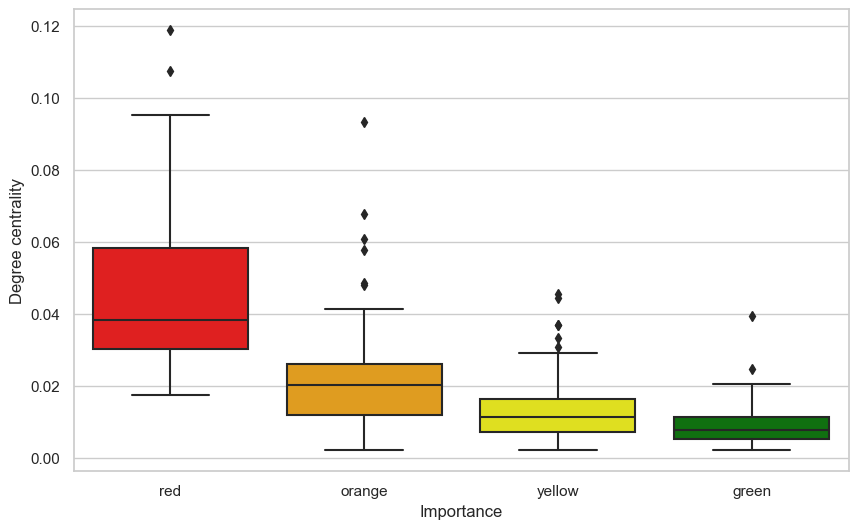

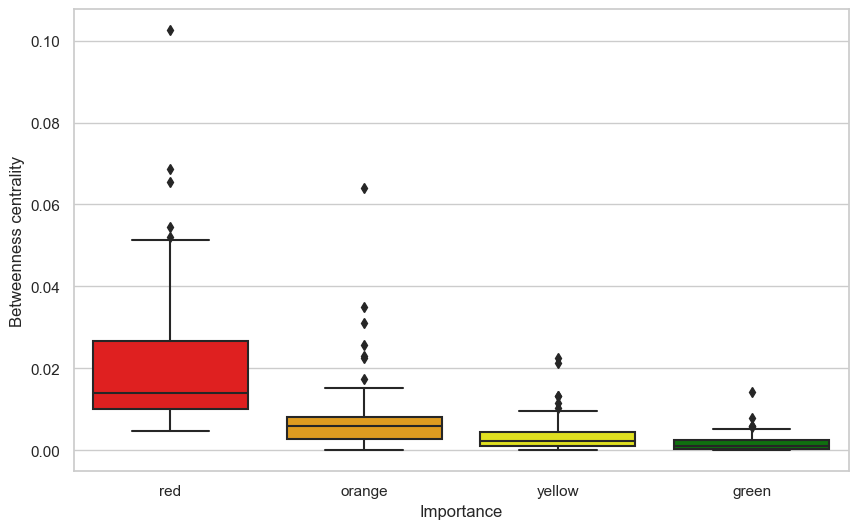

In [14]:
df_box1 = pd.DataFrame(list(zip(character_names, d_centrality, imp)),
               columns =['Name', 'Degree centrality', 'Importance'])
df_box2 = pd.DataFrame(list(zip(character_names, b_centrality, imp)),
               columns =['Name', 'Betweenness centrality', 'Importance'])

# plot box plots
sns.set(rc={'figure.figsize':(10,6)})
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x='Importance',y='Degree centrality',palette=['red','orange', 'yellow','green'],data=df_box1)
plt.savefig("boxplot.png", dpi=600)
plt.show()

sns.set(rc={'figure.figsize':(10,6)})
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x='Importance',y='Betweenness centrality',palette=['red','orange', 'yellow','green'],data=df_box2)
plt.savefig("boxplot2.png", dpi=600)
plt.show()

# Text analysis

## TF-IDF and word clouds

To analyse the Louvain partition, we compute the TF-IDF statistic for the 10 largest communities.

Term Frequency (TF) is simply a count of how often a word occurs in a given document. TF can give a good idea of what words are prevalent in a text, however, if you only look at the most frequent words, the words with the highest TF-scores will be uninteresting words like "the", "and", etc. One way to handle this problem is to simpy remove stop-words from the document, however, the most common words excluding stop-words are still not necessarily the words that tells us the most about the given document. 

We can ensure that we get the most defining terms from a document by multiplying TF by the Inverse document frequency (IDF). IDF counts how many documents a given term is in, and outputs the logarithmically scaled inverse frequency, given by the formula:
$$\operatorname{idf}(t, D)=\log \frac{N}{|\{d \in D: t \in d\}|}$$

Where the numerator $N$ is the amount of total documents, in our case 10, and the denomenator is the amount of documents $d\in D$ containing the term $t$. This means the highest IDF-scores are given to terms that appear in only a single document.

The TF-IDF score is then calculated as 

$$\operatorname{tf-idf}(t,d,D) = \operatorname{tf}(t, d) \cdot \operatorname{idf}(t, D)$$

The resulting score shows if terms occur frequently in the given document, and not in other documents. A high TF-IDF score indicates that the given term is used frequently in the given document, and not in others.

(Source: https://en.wikipedia.org/wiki/Tf%E2%80%93idf & assignment 2.)

In [23]:
with open('louvain.pickle', 'rb') as handle:
    partition = pickle.load(handle)
    
with open('df_final.pickle', 'rb') as handle:
    df_final = pickle.load(handle)

There are 14 communities in total, but we only consider the 10 largest communities.

In [24]:
# we count the number of communities:
print("Number of communities:", len(np.unique(list(partition.values()))))

# And count number of nodes in each community:
partitions = np.unique(list(partition.values()))
partition_dic = {parti: [] for parti in partitions}
for parti in partition_dic.keys():
    count = 0
    for key in partition:
        if partition[key] == parti:
            count += 1
    partition_dic[parti]=count
print("Community sizes:",partition_dic)

top_10 = [x[0] for x in sorted(partition_dic.items(), key=lambda x: x[1], reverse=True)][:10]
print("Top 10 largest communities:", top_10)

Number of communities: 14
Community sizes: {0: 161, 1: 130, 2: 212, 3: 235, 4: 221, 5: 125, 6: 137, 7: 10, 8: 6, 9: 140, 10: 212, 11: 195, 12: 128, 13: 49}
Top 10 largest communities: [3, 4, 2, 10, 11, 0, 9, 6, 1, 12]


We first combine all the character texts within each Louvain community. 

In [25]:
community_dic = {part: [] for part in partition_dic.keys()}
for part in tqdm(partition_dic.keys()):#for each community 
    community_doc = str()
    for node in [key for (key,value) in partition.items() if value==part]:#for each character in that community
        tokens = list(df_final.loc[df_final["Name"]==node]['Clean Text'])#Extract clean text from data frame
        
        if len(tokens)!=0:#handle nodes with no text
            community_doc +=' '+ tokens[0]#add extra space to ensure we can split into tokens later
        else:
            break
    
    community_dic[part]=community_doc

  0%|          | 0/14 [00:00<?, ?it/s]

All the texts are then tokenized using ``word_tokenize`` from nltk. Non-alphanumeric characters such as punctuation and signs are removed. 

In [29]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'

token_dic = {}
for part in tqdm(community_dic.keys()):#for each community
    tokens = word_tokenize(community_dic[part])#divide text into tokens
    text = community_dic[part]
    token_list = []
    for token in tokens:
        if len(token) != 0:
            token = token.lower()
            
            if token[0] in alphabet and token[-1] in alphabet:#remove punctuation and signs
                token_list.append(token)
    token_dic[part]=token_list

  0%|          | 0/14 [00:00<?, ?it/s]

For each community, we compute the term-frequency (TF) for all tokens. 

In [39]:
TF_outer_dic =  {} 
for part in tqdm(top_10):
    TF_dic = {}
    for token in token_dic[part]:
        if token not in TF_dic.keys():
            TF_dic[token]=token_dic[part].count(token)#count frequency
    TF_outer_dic[part]=TF_dic

For each community, we also compute the inverse document frequency (IDF) for all tokens.

In [38]:
N = 10
IDF_outer_dic = {}
for part in top_10:#for each community
    IDF_dic = {}
    for word in tqdm(TF_outer_dic[part].keys()):#for each word in that community
        
        count = 0
        for part2 in top_10:
            if word in token_dic[part2]:
                count += 1 #count occurences in all documents
        IDF_dic[word]=np.log(N/count)#uses natural log
    IDF_outer_dic[part]=IDF_dic

Finally, we multiply TF and IDF for all tokens to obtain the TF-IDF statistic. 

In [ ]:
TF_IDF_outer_dic = {}
for part in tqdm(top_10):
    TF_IDF_dic = {}
    for word in IDF_outer_dic[part].keys():
        TF_IDF_dic[word]=TF_outer_dic[part][word]*IDF_outer_dic[part][word]
    TF_IDF_outer_dic[part]=TF_IDF_dic

We can now generate word clouds for the 10 largest communities. The size of the words on the word clouds are proportional to the TF-IDF statistic. The function ``random_color_func`` generates a random set of hue, saturation and lightness values which we will use to colour the word clouds. It is adapted from: https://stackoverflow.com/a/43043723

In [50]:
# adapted from: https://stackoverflow.com/a/43043723

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * float(np.random.randint(0, 255)) / 255.0)
    s = int(100.0 * float(np.random.randint(0, 255)) / 255.0)
    l = int(100.0 * float(np.random.randint(0, 255)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

The word clouds are created using the Word Cloud module.

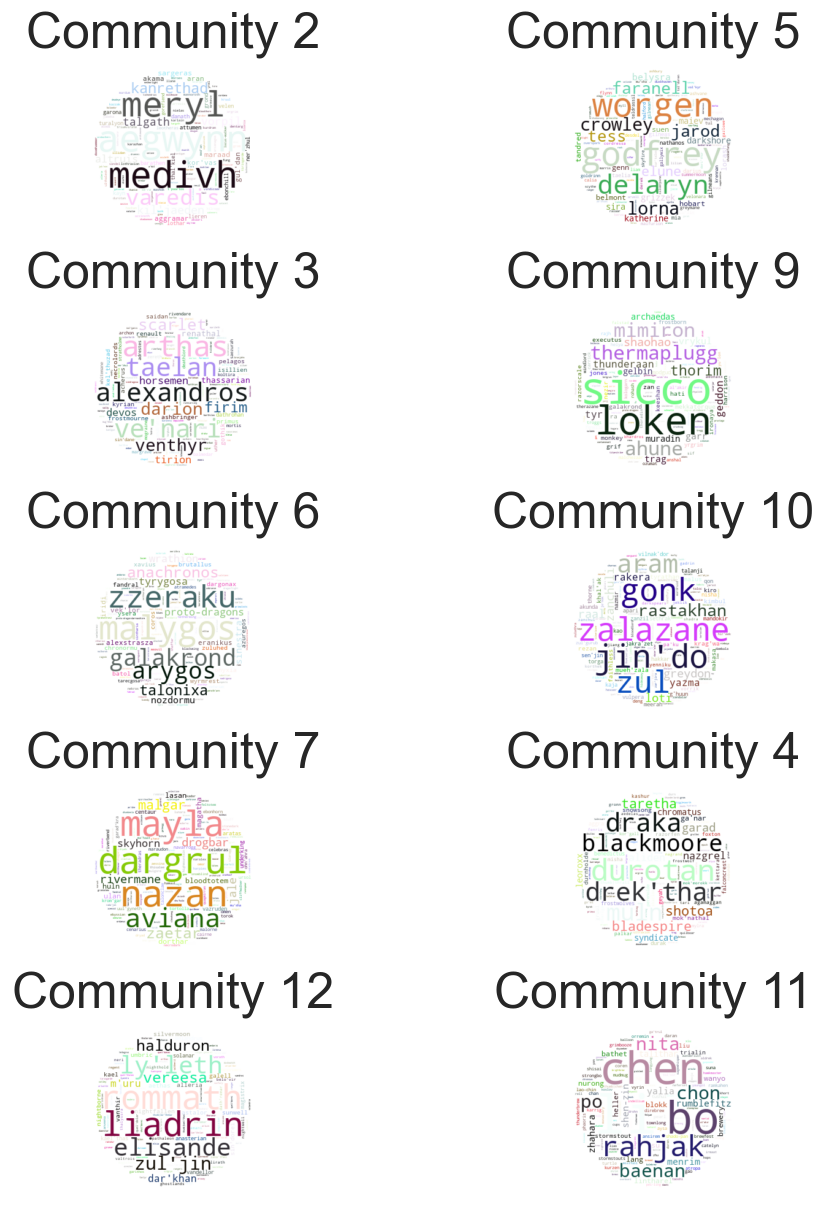

In [54]:
# taken from: https://amueller.github.io/word_cloud/auto_examples/single_word.html#sphx-glr-auto-examples-single-word-py

tf_idf = TF_IDF_outer_dic

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

fig = plt.figure(figsize=(8,10),dpi=120,constrained_layout=True)
i=1

for key in tf_idf.keys():
    TF_IDF = tf_idf[key]
    
    wc = WordCloud(background_color="white", repeat=True, mask=mask, color_func=random_color_func)
    # make wordcloud from TF-IDF
    wordcloud = wc.generate_from_frequencies(TF_IDF)
    
    ax = fig.add_subplot(5,2,i)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title("Community {}".format(key), size=30)
    ax.axis("off")
    i+=1

plt.savefig("wordclouds.png", dpi=400);
    
plt.show()

## Sentiment analysis

In [2]:
#load needed dataframes:
#Dataframe with information about character game appearances:
with open('df_meta.pickle', 'rb') as f:
    df_meta = pickle.load(f)
#Dataframe with character text:
with open('df_final.pickle', 'rb') as f:
    df_text = pickle.load(f)
#Directed graph of all characters
with open('DG.pickle', 'rb') as f:
    DG = pickle.load(f)

## Sentiment over time


We load the wordlist with sentiment scores (as we did in assignment 2).

In [3]:
#Load LabMT word list as dataframe:
df_happy = pd.read_csv('Data_Set_S1.txt', skiprows=2, sep="\t")

First we define some functions that help us calculate the sentiment score.

In [4]:
def text2sentiment_freqdist(freqdist_dic):
    #function taken from our assignment 2
    
    # total happiness score
    happiness_score = 0
    # total count of tokens included in the sentiment score
    w = 0
    
    # iterate over tokens in freqdist
    for token in freqdist_dic.keys():
        # check if token is in the dataframe
        if token in list(df_happy['word']):
            token = token.lower()
            
            # get sentiment score of word and multiply it with how many times it appears in the text 
            score = float(df_happy.loc[df_happy['word'] == token]['happiness_average'])
            happiness_score += freqdist_dic[token]*score
            
            # add how many times the token appears to total count
            w += freqdist_dic[token]
    
    # if total token count is 0, return 0. Else divide total happiness score with total token count
    if w == 0:
           return 0
    else:
        return happiness_score / w

In [5]:
#the following is also based on assignment 2 code:
for i, name in enumerate(tqdm(df_text['Name'])):   
    if name in DG.nodes():
        # tokenize text from character page and turn into FreqDist dictionary
        tokens = df_text['Clean Text'].iloc[i].split()
        freqdist_dic = nltk.FreqDist(tokens)
        
        # assign sentiment score as new attribute in the graph
        sentiment_score = text2sentiment_freqdist(freqdist_dic)
        DG.nodes()[name]['sentiment'] = sentiment_score

100%|██████████████████████████████████████████████████████████████████████████████| 1961/1961 [18:34<00:00,  1.76it/s]


In [6]:
mean_sent=np.mean([value for (name,value) in list(DG.nodes('sentiment'))]) #Find mean sentiment score for all characters
print('Mean sentiment score: ',mean_sent)

Mean sentiment score:  5.253193968264166


Above we have the mean sentiment score for all characters in the data set. It is lower than the average sentiment score for the wordlist that is used to calculate the sentiment scores.

In [7]:
df_happy['happiness_average'].values.mean()#Mean sentiment for the word list that the sentiment scores are based on

5.375239679123459

In [8]:
#Find all Horde and Alliance characters
Horde = df_text[df_text.Affiliation=='Horde']['Name']
Alliance = df_text[df_text.Affiliation=='Alliance']['Name']
games = ['WC1','WC2','WC2X','WC3','WC3X','WoW','WoWBC','WoWWotLK','WoWC','WoWMoP','WoWWoD','WoWL','WoWBfA','WoWS'] #list of games/expansions considered for sentiment analysis.


In [9]:
#dictionaries for storing sentiment scores
games_sent = {}
games_sent_horde = {}
games_sent_alliance = {}
#Find sentiment scores for all Horde and Alliance characters that appear in a given game and append the score to the list of their respective faction. 
for game in tqdm(games): 
    h = []
    a = []
    for name in Horde:
        if name in df_meta[df_meta[game]==1].Name.values:
            h.append(DG.nodes()[name]['sentiment'])
    games_sent_horde[game]=np.mean(h)#Calculate mean sentiment score for Horde characters in the given game.
    for name in Alliance:
        if name in df_meta[df_meta[game]==1].Name.values:
            a.append(DG.nodes()[name]['sentiment'])
    games_sent_alliance[game]=np.mean(a)#Calculate mean sentiment score for Alliance characters in the given game.
games_sent = {'Horde':games_sent_horde, 'Alliance':games_sent_alliance}

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.23it/s]


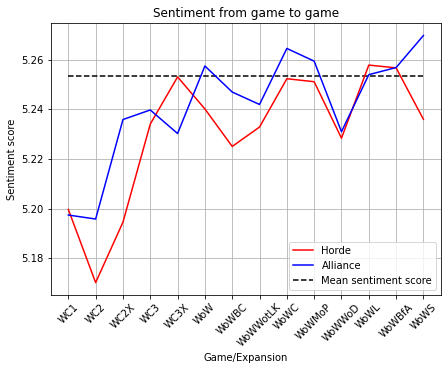

In [10]:
#plot of mean sentiment
plt.figure(figsize=(7,5))
plt.plot(games_sent['Horde'].values(),'r',label='Horde')
plt.plot(games_sent['Alliance'].values(),'b',label='Alliance')
plt.title('Sentiment from game to game')

plt.xticks(range(len(games)),games,rotation=45)
plt.grid()
plt.ylabel('Sentiment score')
plt.xlabel('Game/Expansion')
plt.hlines(mean_sent,xmin=0,xmax=13, color='black',linestyles='--',label='Mean sentiment score')
plt.legend()
plt.show()

In [162]:
#save Graph with sentiment scores as attribute
filepath = os.getcwd()
with open(filepath+'\\DG_sent.pickle', 'wb') as handle:
    pickle.dump(DG, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
#Count how many characters of each faction that appear in each game.
#This is done similarly to how the sentiment score was calculated.
#For each character in a given game that belongs to either the Horde or the Alliance, the respective factions counter ticks up
#THis count only consideres major characters, since the game metadata only exists for them.
game_fac_h = {}
game_fac_a = {}
for game in tqdm(games):
    h_count = 0
    a_count = 0
    for name in Horde:
        if name in df_meta[df_meta[game]==1].Name.values:
            h_count +=1
                          
    for name in Alliance:
        if name in df_meta[df_meta[game]==1].Name.values:
            a_count +=1
    #the counts for each faction is saved for each game
    game_fac_h[game]=h_count
    game_fac_a[game]=a_count
game_fac={'Horde':game_fac_h,'Alliance':game_fac_a}

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.34it/s]


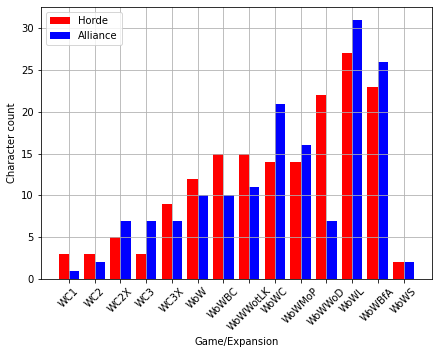

In [12]:
#Bar plot of Horde and Alliance character count.
horde_count=list(game_fac['Horde'].values())
alliance_count = list(game_fac['Alliance'].values())
plt.figure(figsize=(7,5))
plt.bar(np.array(range(len(game_fac['Horde'].keys())))-0.2,horde_count,color='r',tick_label=list(game_fac['Horde'].keys()),width=0.4,label='Horde')
plt.bar(np.array(range(len(game_fac['Alliance'].keys())))+0.2,alliance_count,color='b',tick_label=list(game_fac['Alliance'].keys()),width=0.4,label='Alliance')
plt.legend()
plt.xticks(range(len(games)),games,rotation=45)
plt.ylabel('Character count')
plt.xlabel('Game/Expansion')
plt.grid()
# plt.yscale('log')
# plt.title('Character count')
plt.show()


We want to understand what kind of characters gets high and low sentiment scores. We threshold the sentiment scores so only the most positive and negative texts remain.

In [13]:
evil_names=sorted([name for (name,value) in list(DG.nodes('sentiment')) if value<5])
good_names=sorted([name for (name,value) in list(DG.nodes('sentiment')) if value>5.6])
print(len(good_names),len(evil_names))

11 30


We see that there are more characters with a sentiment score under 5 than characters with a sentiment score over 5.6.
By reading the wiki-pages of the cahraceters with the lowest and highest sentiment scores, we see that they have very short texts. We now want to see if length of a characters wiki-page has an impact on the sentiment score.

In [14]:
#Calculate the mean ammount of characters in a text for characters with a sentiment score below 5 compared to those with a sentiment score above 5.3, and all characters
print(np.mean([len(str(df_text['Clean Text'][df_text['Name']==name].values)) for name in good_names]))
print(np.mean([len(str(df_text['Clean Text'][df_text['Name']==name].values)) for name in evil_names]))
print(np.mean([len(str(df_text['Clean Text'][df_text['Name']==name].values)) for name in df_text['Name']]))

863.5454545454545
632.8
5676.060173380928


We can see that the characters we found with our threshold of sentiment scores before, have relatively short texts in terms of amount of characters.

In [15]:
#Sort characters by sentiment scores
temp_sent_list = sorted([(value, name) for (name,value) in list(DG.nodes('sentiment'))])
sorted_sent = [value for (value,name) in temp_sent_list]
sorted_len = [len(nltk.FreqDist(str(df_text['Clean Text'][df_text['Name']==name].values).split())) for (value,name) in temp_sent_list]

We have now sorted the characters by sentiment score and found the length of their associated text by the amount of words(tokens). We can now plot the rolling average text length by the sentiment scores. The rolling average takes a window of 100 samples (result is assigned to the right-most index in the window) and averages them with a uniform weigthing. This smoothes the plot, making it easier to see the underlying trend.

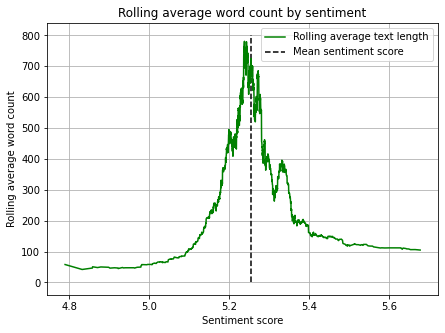

In [24]:
sent_len_df = pd.DataFrame(np.array([sorted_sent, sorted_len]).T,columns=['Sentiment_score','Length_of_text'])
# print(sent_len_df['Length_of_text'])
rolled_series = sent_len_df['Length_of_text'].rolling(100,min_periods=1).mean()
# print(rolled_series)
plt.figure(figsize=(7,5))
plt.plot(sorted_sent,rolled_series,'g',label='Rolling average text length')
# plt.yscale('log')
plt.title('Rolling average word count by sentiment')
plt.ylabel('Rolling average word count')
plt.xlabel('Sentiment score')
plt.vlines(mean_sent,ymin=0,ymax=800, color='black',linestyles='--',label='Mean sentiment score')
plt.grid()
plt.legend()

This shows us that the sentiment score of a text approaches the mean when as the text gets longer. So a long text will be more likely to have a sentiment score of around 5.25. 

In [25]:
#Find text length for each character appearing in each game
game_fac_h = {}
game_fac_a = {}
for game in tqdm(games):
    h_count = 0
    a_count = 0
    for name in Horde:
        if name in df_meta[df_meta[game]==1].Name.values:#find Horde characters that appeared in the given game
            h_count +=len(nltk.FreqDist(str(df_text['Clean Text'][df_text['Name']==name].values).split())) #Add their texts word count to the sum
                          
    for name in Alliance:
        if name in df_meta[df_meta[game]==1].Name.values:
            a_count +=len(nltk.FreqDist(str(df_text['Clean Text'][df_text['Name']==name].values).split()))
    #save the cumulative text lenght in terms of amount of tokens for each faction for each game.
    game_fac_h[game]=h_count 
    game_fac_a[game]=a_count
game_fac={'Horde':game_fac_h,'Alliance':game_fac_a}

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.81it/s]


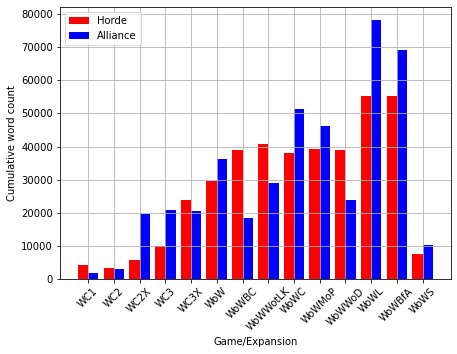

In [26]:
#plot cumulative word count
plt.figure(figsize=(7,5))
plt.bar(np.array(range(len(game_fac['Horde'].keys())))-0.2,list(game_fac['Horde'].values()),color='r',tick_label=list(game_fac['Horde'].keys()),width=0.4,label='Horde')
plt.bar(np.array(range(len(game_fac['Alliance'].keys())))+0.2,list(game_fac['Alliance'].values()),color='b',tick_label=list(game_fac['Alliance'].keys()),width=0.4,label='Alliance')
plt.legend()
plt.xticks(range(len(games)),games,rotation=45)
plt.ylabel('Cumulative word count')
plt.xlabel('Game/Expansion')
plt.grid()
# plt.yscale('log')
# plt.title('Character count')
plt.show()


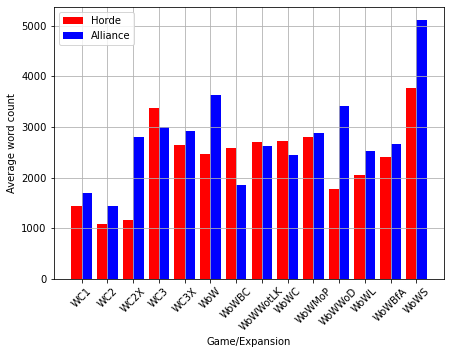

In [27]:
#Calculate mean length of text(word count) for each character of each faction in a given game.
h_val = np.divide(np.array(list(game_fac['Horde'].values())),np.array(horde_count))
a_val = np.divide(np.array(list(game_fac['Alliance'].values())),np.array(alliance_count))
plt.figure(figsize=(7,5))
plt.bar(np.array(range(len(game_fac['Horde'].keys())))-0.2,h_val,color='r',tick_label=list(game_fac['Horde'].keys()),width=0.4,label='Horde')
plt.bar(np.array(range(len(game_fac['Alliance'].keys())))+0.2,a_val,color='b',tick_label=list(game_fac['Alliance'].keys()),width=0.4,label='Alliance')
plt.legend()
plt.xticks(range(len(games)),games,rotation=45)
plt.ylabel('Average word count')
plt.xlabel('Game/Expansion')
plt.grid()
# plt.yscale('log')
# plt.title('Character count')
plt.show()

We want to see the summary statistics of the sentiment scores for Horde and Alliance ( the following code until "Directed sentiment is adapted from our assignment2).

In [28]:
#Calculate the mean sentiment scores of each faction. Includes all characters from all games + non-major characters.
h_sent = []
a_sent = []
for name in Horde:
    h_sent.append(DG.nodes()[name]['sentiment'])
horde_sent = np.mean(h_sent)
for name in Alliance:
    a_sent.append(DG.nodes()[name]['sentiment'])
alliance_sent = np.mean(a_sent)
print('Alliance Sentiment score: {}'.format(alliance_sent),'\nHorde Sentiment score: {}'.format(horde_sent))
    

Alliance Sentiment score: 5.251297883405995 
Horde Sentiment score: 5.222782740899875


In [29]:
print("Number of Horde characters:", len(Horde))
print("Number of Alliance characters:", len(Alliance))



Number of Horde characters: 119
Number of Alliance characters: 99


In [30]:
# calculate mean, median, 10th percentile, 90th percentile for Alliance characters
a_sent = [a for a in a_sent if a != 0] # remove 0s
mean = alliance_sent
median = np.median(a_sent)
p10 = np.percentile(a_sent, q=10)
p90 = np.percentile(a_sent, q=90)

print("Statistics for Alliance characters")
print("Mean:", round(mean,3))
print("Median", round(median,3))
print("10th percentile", round(p10,3))
print("90th percentile", round(p90,3))

Statistics for Alliance characters
Mean: 5.251
Median 5.244
10th percentile 5.19
90th percentile 5.315


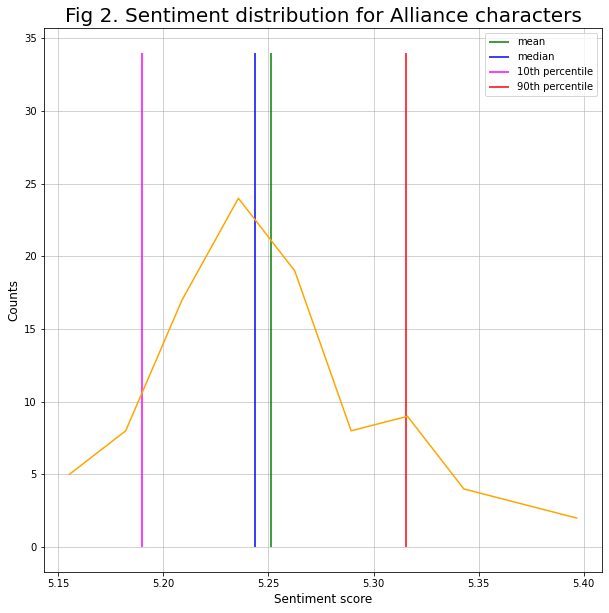

In [31]:
height, bins = np.histogram(a_sent, bins=10)

binmids = []
for i in range(len(bins)-1):
    binmids.append((bins[i]+bins[i+1])/2)
    
    
fig, ax = plt.subplots(1 ,figsize=(10,10))

plt.title('Fig 2. Sentiment distribution for Alliance characters', size=20)
plt.xlabel('Sentiment score', size=12)
plt.ylabel('Counts', size=12)
plt.plot(binmids, height, color='orange')
plt.grid(alpha=0.7)
plt.rc('axes', axisbelow=True)
plt.vlines(mean, 0, max(height)+10, color='green', label='mean')
plt.vlines(median, 0, max(height)+10, color='blue', label='median')
plt.vlines(p10, 0, max(height)+10, color='magenta', label='10th percentile')
plt.vlines(p90, 0, max(height)+10, color='red', label='90th percentile')
plt.legend();


We also compute the mean, median, 10th percentile, and 90th percentile for the horde characters and plot the distribution of sentiment values.

In [32]:
# calculate mean, median, 10th percentile, 90th percentile for horde characters
h_sent = [b for b in h_sent if b != 0] # remove 0s
mean = np.mean(h_sent)
median = np.median(h_sent)
p10 = np.percentile(h_sent, q=10)
p90 = np.percentile(h_sent, q=90)

print("Statistics for horde characters")
print("Mean:", round(mean,3))
print("Median", round(median,3))
print("10th percentile", round(p10,3))
print("90th percentile", round(p90,3))

Statistics for horde characters
Mean: 5.223
Median 5.237
10th percentile 5.126
90th percentile 5.318


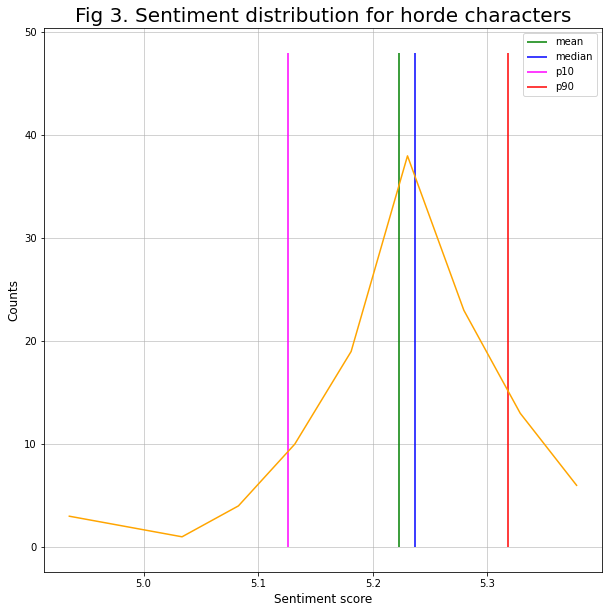

In [33]:
height, bins = np.histogram(h_sent, bins=10)

binmids = []
for i in range(len(bins)-1):
    binmids.append((bins[i]+bins[i+1])/2)
    
    
fig, ax = plt.subplots(1 ,figsize=(10,10))

plt.title('Fig 3. Sentiment distribution for horde characters', size=20)
plt.xlabel('Sentiment score', size=12)
plt.ylabel('Counts', size=12)
plt.plot(binmids, height, color='orange')
plt.grid(alpha=0.7)
plt.rc('axes', axisbelow=True)
plt.vlines(mean, 0, max(height)+10, color='green', label='mean')
plt.vlines(median, 0, max(height)+10, color='blue', label='median')
plt.vlines(p10, 0, max(height)+10, color='magenta', label='p10')
plt.vlines(p90, 0, max(height)+10, color='red', label='p90')
plt.legend();
# plt.xlim(min_, max_+1);

The Distributions for Horde and Alliance character sentiment scores are somewhat similar, both peaking at just below 5.25. We now perform permutation tests to see if either faction has significantly lower sentiment scores than the other.

In [34]:
def get_horde_and_alliance_graph(G):

    alliance_subgraph = [n for n in DG.nodes() if n in Alliance.values]
    alliance = G.subgraph(alliance_subgraph)

    horde_subgraph = [n for n in DG.nodes() if n in Horde.values]
    horde = G.subgraph(horde_subgraph)

    return alliance, horde

In [35]:
def get_permuted_sentiments(graph):
    # get number of nodes of graph
    M = len(graph.nodes())
    print("Number of characters:", M)
    
    permuted_sentiments = []
    # permute 1000 times
    for i in tqdm(range(1000)):
        # randomly choose M nodes from graph G
        permute = random.sample(list(DG.nodes()), M)
        
        # get sentiment and append
        sentiment = np.mean([DG.nodes()[node]['sentiment'] for node in permute if DG.nodes()[node]['sentiment'] != 0])
        permuted_sentiments.append(sentiment)
    
    return permuted_sentiments

In [37]:
# get Alliance and Horde partition
alliance, horde = get_horde_and_alliance_graph(DG)

# get sentiments of Alliance and Horde characters respectively
avg_sentiment_A = [DG.nodes[node]['sentiment'] for node in alliance.nodes()]
avg_sentiment_H = [DG.nodes[node]['sentiment'] for node in horde.nodes()]

In [38]:
# mean sentiment values
print("Mean sentiment value for alliance characters:", round(np.mean(avg_sentiment_A),3))
print("Mean sentiment value for horde characters:", round(np.mean(avg_sentiment_H),3))

Mean sentiment value for alliance characters: 5.251
Mean sentiment value for horde characters: 5.223


Number of characters: 99


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2434.13it/s]


The mean of the distribution is: 5.254


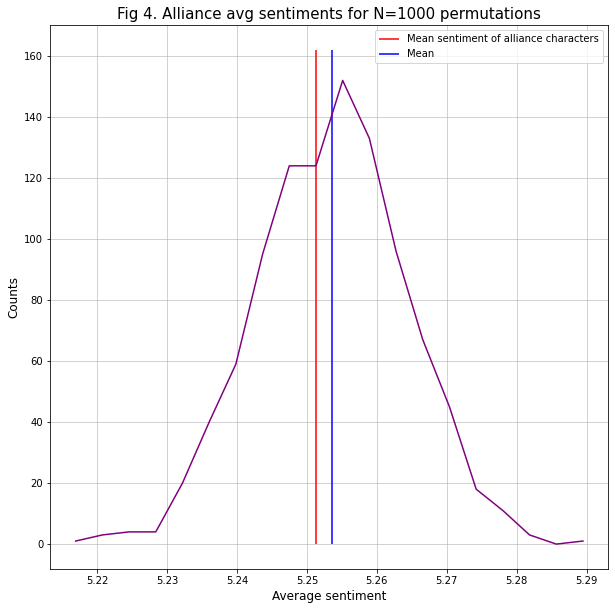

In [39]:
#Alliance
sentiment_As = get_permuted_sentiments(alliance)

print("The mean of the distribution is:", round(np.mean(sentiment_As),3))

minX, maxX  = min(sentiment_As), max(sentiment_As)

height, bins = np.histogram(sentiment_As, bins=20)

binmids = []
for i in range(len(bins)-1):
    binmids.append((bins[i]+bins[i+1])/2)

fig, ax = plt.subplots(1 ,figsize=(10,10))    
    
plt.title('Fig 4. Alliance avg sentiments for N=1000 permutations', size=15)
plt.xlabel('Average sentiment', size=12)
plt.ylabel('Counts', size=12)
plt.plot(binmids, height, color='purple')
plt.grid(alpha=0.7)
plt.vlines(np.mean(avg_sentiment_A), 0, max(height)+10, color='red', label='Mean sentiment of alliance characters')
plt.vlines(np.mean(sentiment_As), 0, max(height)+10, color='blue', label='Mean')
plt.legend()
plt.rc('axes', axisbelow=True)

We observe that the mean sentiment score for Alliance characters is close to the mean for the whole data set.

Number of characters: 119


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2308.19it/s]


The mean of the distribution is: 5.254


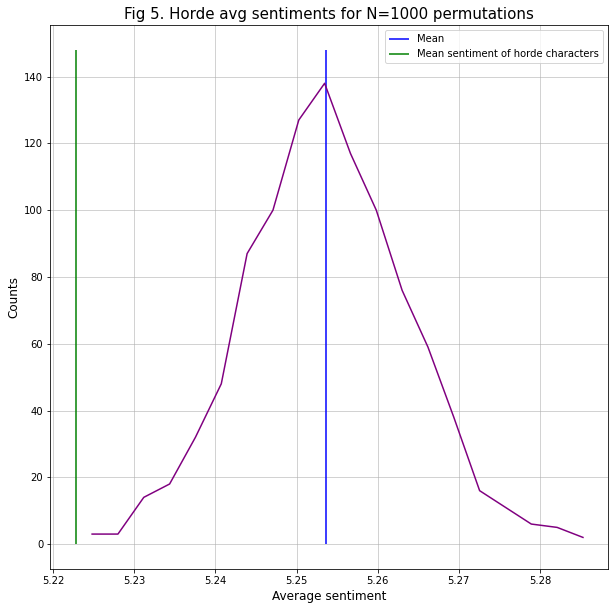

In [40]:
# Horde
sentiment_Hs = get_permuted_sentiments(horde)

print("The mean of the distribution is:", round(np.mean(sentiment_Hs),3))

minX, maxX  = min(sentiment_Hs), max(sentiment_Hs)

height, bins = np.histogram(sentiment_Hs, bins=20)

binmids = []
for i in range(len(bins)-1):
    binmids.append((bins[i]+bins[i+1])/2)

fig, ax = plt.subplots(1 ,figsize=(10,10))    
    
plt.title('Fig 5. Horde avg sentiments for N=1000 permutations', size=15)
plt.xlabel('Average sentiment', size=12)
plt.ylabel('Counts', size=12)
plt.plot(binmids, height, color='purple')
plt.grid(alpha=0.7)
plt.vlines(np.mean(sentiment_Hs), 0, max(height)+10, color='blue', label="Mean")
plt.vlines(np.mean(avg_sentiment_H), 0, max(height+10), color='green', label="Mean sentiment of horde characters")
plt.legend()
plt.rc('axes', axisbelow=True)

On the contrary, the average sentiment for the Horde characters is significantly below the mean. From this we can conclude that the Horde characters have a significantly lower sentiment score than the Alliance characters. This result indicates that Alliance characters are described more positively than Horde characters.

### Directed Sentiment
Are the horde more hostile towards the alliance or opposite. Do they always interact in negative situations or do they share good times? In order to measure this, we find the sentences in each characters text that mention other characters and calculate the sentiment for those. The resulting score is added as an attribute to the directed edge from one character to the other. 

In [41]:
#load dictionary of character aliases. Needed later
with open('max_char2aliases.pickle', 'rb') as f:
    max2A_dic = pickle.load(f)

In [144]:
success_count = 0
fail_count = 0
attribute_dic = {} #define dictionary to save sentiment scores
for name in tqdm(DG.nodes()): #loop over characters
    for char in df_text['Out Links'][df_text['Name']==name].values[0]: #Loop over the characters link to
        reg_exp = '[^.]*{}.[^.]*\.'.format(char.replace('_',' ')) #Use regex to find sentences where the characters are mentioned
        text = str(df_text['Clean Text'][df_text['Name']==name].values).replace('\\','')
        match = re.findall(reg_exp, text)
#         print(name,char,match)
        
 
        try:
            aliases = max2A_dic[char] #if character has aliases, check if their aliases are mentioned
            for alias in aliases:
                reg_exp = '[^.]*{}.[^.]*\.'.format(alias.replace('_',' '))
                alias_match = re.findall(reg_exp, text)
                for item in alias_match:
                    if item not in match:#Only add sentences that were not already found. Necessary as some characters aliases are subsets of their name(e.g first name only).
#                         print('Alias:',item,'Match:', match, name, char)
                        match.append(item)
                        
#                     print('success for:',name,char)
        except:
                None
        if match!=[]:
            tokens = [t.split() for t in match]#split text into tokens
            tokens = [item for sublist in tokens for item in sublist]
            freqdist_dic = nltk.FreqDist(tokens) 
            sentiment_score = text2sentiment_freqdist(freqdist_dic)#calculate sentiment score for all tokens.
            attribute_dic[(name,char)]=(sentiment_score,match)#save sentiment score for edge
            success_count +=1
        else:#If the character is linked to on a characters page, but does not appear in the clean text, we ignore that particular edge.
#             print('oops, problem with',name,char)
            fail_count +=1
   

100%|██████████████████████████████████████████████████████████████████████████████| 1961/1961 [29:58<00:00,  1.09it/s]


There are 643 links where the linked characters are not mentioned in the clean text. These are simply disregarded for the directed sentiment analysis.

In [145]:
nx.set_edge_attributes(DG, attribute_dic, 'Sentiment_edge')#Save the sentiment as edge attributes

In [147]:
#save graph with edge attributes and the attribute dictionary
filepath = os.getcwd()
with open(filepath+'\\DG_sent.pickle', 'wb') as handle:
    pickle.dump(DG, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(filepath+'\\edge_sent_dic.pickle', 'wb') as handle:
    pickle.dump(attribute_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)  

In [147]:
#save graph with edge attributes and the attribute dictionary
filepath = os.getcwd()
with open(filepath+'\\DG_sent.pickle', 'wb') as handle:
    pickle.dump(DG, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(filepath+'\\edge_sent_dic.pickle', 'wb') as handle:
    pickle.dump(attribute_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)  

In [148]:
#Calculate means for faction to faction sentiment
for edge in DG.edges():
    if edge in attribute_dic.keys():#check if sentiment has been calculated for the edge
        if edge[0] in Alliance.values and edge[1] in Alliance.values:#Alliance to alliance sentiment
            A2A.append(attribute_dic[edge][0])
        elif edge[0] in Alliance.values and edge[1] in Horde.values:#Alliance to horde sentiment
            A2H.append(attribute_dic[edge][0])
        elif edge[0] in Horde.values and edge[1] in Alliance.values:#Horde to alliance sentiment
            H2A.append(attribute_dic[edge][0])
        elif edge[0] in Horde.values and edge[1] in Horde.values:#Horde to horde sentiment
            H2H.append(attribute_dic[edge][0])
print('Mean sentiment for Alliance to Alliance:',np.mean(A2A))
print('Mean sentiment for Alliance to Horde:',np.mean(A2H))
print('Mean sentiment for Horde to Alliance:',np.mean(H2A))
print('Mean sentiment for Horde to Horde:',np.mean(H2H))
        

Mean sentiment for Alliance to Alliance: 5.244740014158619
Mean sentiment for Alliance to Horde: 5.2214226725570105
Mean sentiment for Horde to Alliance: 5.204189698125854
Mean sentiment for Horde to Horde: 5.227197251684637


We can see that the sentiment from the Alliance to the Alliance is the highest among the mean directed sentiments from faction to faction. This is somewhat expected as Alliance characters in general have higher average sentiment scores.

In [149]:
#Sanity check, delete?
for edge in DG.edges():
    print(attribute_dic[edge][0])
    break
('Brann_Bronzebeard','Dagran_Thaurissan_II') in nx.get_edge_attributes(DG,'Sentiment_edge').keys()

5.354210526315788


False

In [43]:
#Load previoulsy saved dicts
with open('DG_sent.pickle', 'rb') as f:
    DG = pickle.load(f)
with open('edge_sent_dic.pickle', 'rb') as f:
    attribute_dic = pickle.load(f)

Now that we have calculated the sentiment for each character pair, we can find the mean directed sentiment for major characters of each faction that appear in each game/expansion, as we did with regular sentiment score before.

In [150]:
#Find all Horde and Alliance characters
Horde = df_text[df_text.Affiliation=='Horde']['Name']
Alliance = df_text[df_text.Affiliation=='Alliance']['Name']
#same games list as earlier
games = ['WC1','WC2','WC2X','WC3','WC3X','WoW','WoWBC','WoWWotLK','WoWC','WoWMoP','WoWWoD','WoWL','WoWBfA','WoWS']


games_sent_d = {}
games_sent_A2A = {}
games_sent_A2H = {}
games_sent_H2A = {}
games_sent_H2H = {}
character_sent = {}
for game in tqdm(games):
    A2A = []
    A2H = []
    H2A = []
    H2H = []
    h = []
    a = []
    for edge in DG.edges():
        if edge[0] in df_meta[df_meta[game]==1].Name.values and edge in attribute_dic.keys():           
            if edge[0] in Alliance.values and edge[1] in Alliance.values:
                A2A.append(attribute_dic[edge][0])
            elif edge[0] in Alliance.values and edge[1] in Horde.values:
                A2H.append(attribute_dic[edge][0])
            elif edge[0] in Horde.values and edge[1] in Alliance.values:
                H2A.append(attribute_dic[edge][0])
            elif edge[0] in Horde.values and edge[1] in Horde.values:
                H2H.append(attribute_dic[edge][0])
    #Save mean directed sentiment for each faction to faction combination
    games_sent_A2A[game]=np.mean(A2A)
    games_sent_A2H[game]=np.mean(A2H)
    games_sent_H2A[game]=np.mean(H2A)
    games_sent_H2H[game]=np.mean(H2H)
games_sent_d = {'A2A':games_sent_A2A, 'A2H':games_sent_A2H,'H2A':games_sent_H2A, 'H2H':games_sent_H2H }


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:26<00:00,  6.19s/it]


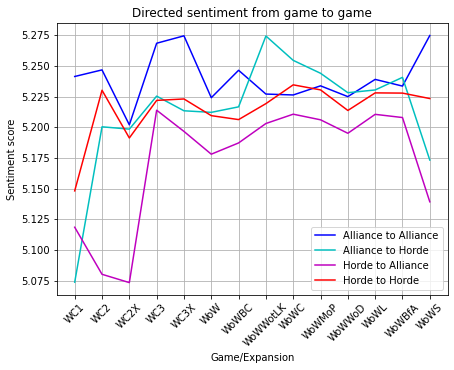

In [152]:
#plot directed sentiment over time.
plt.figure(figsize=(7,5))
plt.plot(games_sent_d['A2A'].values(),'b')
plt.plot(games_sent_d['A2H'].values(),'c')
plt.plot(games_sent_d['H2A'].values(),'m')
plt.plot(games_sent_d['H2H'].values(),'r')
plt.title('Directed sentiment from game to game')
# plt.hlines(mean_sent,xmin=0,xmax=13, color='black',linestyles='--',label='Mean Sentiment score')
plt.legend(['Alliance to Alliance','Alliance to Horde','Horde to Alliance','Horde to Horde','Mean sentiment score'])
plt.xticks(range(len(games)),games,rotation=45)
plt.grid()
plt.ylabel('Sentiment score')
plt.xlabel('Game/Expansion')
plt.show()

We see that the Alliance to Horde sentiment is surprisingly high for WoWWotLK. We want to look closer as to why. To do this, we find the Alliance to Horde edge with the highest sentiment score.

In [189]:

temp_list=[char for char in df_meta[df_meta['WoWWotLK']==1].Name.values if char in Alliance.values]
temp_list2 =[char for char in df_meta[df_meta['WoWWotLK']==1].Name.values if char in Horde.values]
# Horde.values
temp_edges=[edge for edge in attribute_dic.keys() if edge[0] in temp_list and edge[1] in temp_list2]
temp_edges
# [(name,value) for ]
A2H_max_s=sorted([attribute_dic[item] for item in temp_edges])
    
print(A2H_max_s[-1],A2H_max_s[-2])


(5.586666666666666, ["nnThe Vow EternalnnMuradin and his family were among those who attended the wedding of Lor'themar Theron and Thalyssra."]) (5.586666666666666, ["nnThe Vow EternalnnBrann and his family were among those who attended the wedding of Lor'themar Theron and Thalyssra."])


The edge with the highest sentiment score is actually to edges with almost identical text. This is for both Muradin and Brann Bronzebeard to Lor'themar Theron. The text explains that the dwarves attended Lor'themar's wedding.